# Определение суицидальных намерений
Даны промаркированные твиты на русском языке, цель обучить модель для определения наличия у автора твита желания самоубийства.
Данные взяты с Kaggle:
* https://www.kaggle.com/datasets/eldamar1717/depression-suicide-twits-ru

In [ ]:
#!pip install nltk optuna wordcloud catboost -q

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from optuna.integration import OptunaSearchCV
from optuna import distributions
from wordcloud import WordCloud
from catboost import CatBoostClassifier
from wordcloud import STOPWORDS

In [ ]:
#nltk.download()

## Загрузка и первичный анализ данных

In [2]:
df_tweets = pd.read_json("RU_suicide_tweets.json", orient='records')

Дадим названия колонкам

In [3]:
df_tweets.columns = ['tweet', 'sentiment']

Рассмотрим основную информацию

In [4]:
print(df_tweets.info())
df_tweets.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47997 entries, 0 to 47996
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      47997 non-null  object
 1   sentiment  47997 non-null  object
dtypes: object(2)
memory usage: 750.1+ KB
None


,tweet,sentiment
0,Бывшая жена угрожает самоубийством Недавно я н...,suicide
1,"Я странный? На меня не влияют комплименты, есл...",non-suicide
2,Наконец-то 2020 год почти закончился... Так чт...,non-suicide
3,"мне нужна помощь, просто помоги мне, я так плачу",suicide
4,"Я так растеряна. Здравствуйте, меня зовут Адам...",suicide
5,"Честно говоря, я не знаю, что я вообще здесь д...",suicide
6,[Триггерное предупреждение] Оправдание за нане...,suicide
7,Это закончится сегодня вечером. Я больше не мо...,suicide
8,"Все хотят быть «резкими», и это заставляет мен...",non-suicide
9,Моя жизнь закончилась в 20 лет. Всем привет. Я...,suicide


Проверим на пропуски и дубликаты

In [5]:
print("Количество дубликатов =", df_tweets.duplicated().sum())
print("Количество пропусков ", df_tweets.isna().sum(), sep='\n')

Количество дубликатов = 4
Количество пропусков 
tweet        0
sentiment    0
dtype: int64


In [6]:
df_tweets = df_tweets.drop_duplicates()

Проверим столбец с маркерами на опечатки

In [7]:
df_tweets['sentiment'].unique()

array(['suicide', 'non-suicide'], dtype=object)

## Анализ данных

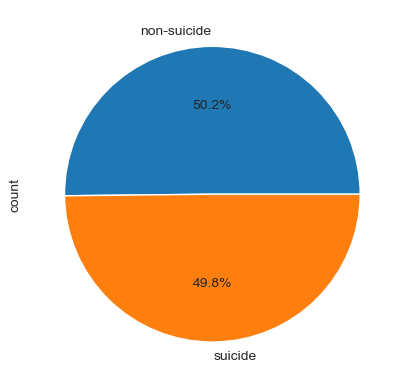

In [8]:
df_tweets['sentiment'].value_counts().plot.pie(autopct="%1.1f%%");

Как видим в представленных данных нет дисбаланса классов

Напишем функции для создания облака слов

In [ ]:
# Function to concatenate words in a list into a single string
def str_corpus(corpus):
    str_corpus = ''
    # Concatenate each word in the list
    for i in corpus:
        str_corpus += ' ' + i
    # Remove leading and trailing whitespaces
    str_corpus = str_corpus.strip()
    return str_corpus

# Function to extract all words from a list of phrases
def get_corpus(data):
    corpus = []
    # Iterate through each phrase in the data
    for phrase in data:
        # Split each phrase into words and add them to the corpus list
        for word in phrase.split():
            corpus.append(word)
    return corpus

# Function to generate a WordCloud
def get_wordcloud(corpus):
    # Create a WordCloud with specified parameters
    wordCloud = WordCloud(
        background_color='white',
        stopwords=STOPWORDS,
        width=3000,
        height=2500,
        max_words=200,
        random_state=42
    ).generate(str_corpus(corpus))  # Generate WordCloud using the concatenated string
    return wordCloud

Воспользуемся написанными функциями

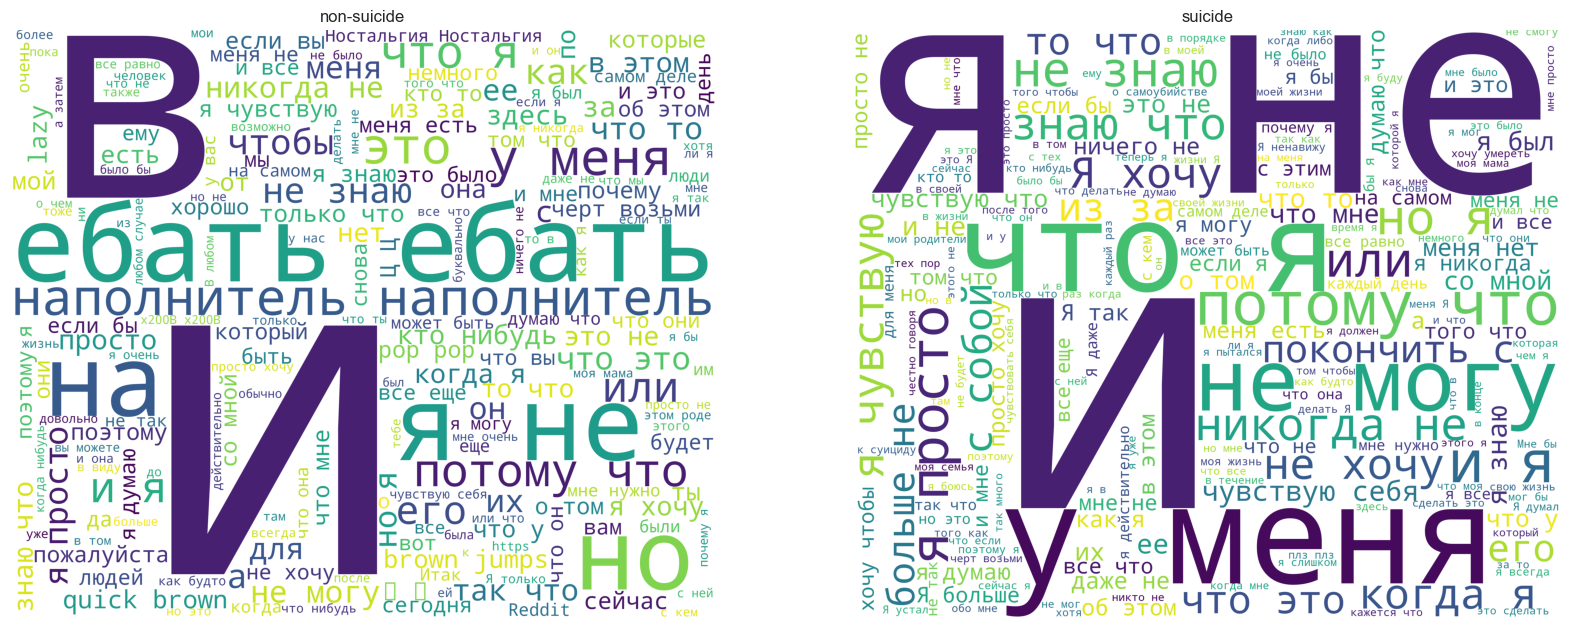

In [85]:
# Create a figure with a specified size
fig = plt.figure(figsize=(20, 8))

# Plot the WordCloud for non-suicide tweets in the first subplot
plt.subplot(1, 2, 1)

# Get the corpus for non-suicide tweets using the 'tweet' column in the DataFrame
corpus_non_suicide = get_corpus(df_tweets[df_tweets['sentiment'] == 'non-suicide']['tweet'].values)

# Generate a WordCloud for the non-suicide tweets
wordcloud_non_suicide = get_wordсloud(corpus_non_suicide)

# Display the WordCloud for non-suicide tweets in the first subplot
plt.imshow(wordcloud_non_suicide)
plt.title('non-suicide')
plt.axis('off')

# Plot the WordCloud for suicide tweets in the second subplot
plt.subplot(1, 2, 2)

# Get the corpus for suicide tweets using the 'tweet' column in the DataFrame
corpus_suicide = get_corpus(df_tweets[df_tweets['sentiment'] == 'suicide']['tweet'].values)

# Generate a WordCloud for the suicide tweets
wordcloud_suicide = get_wordcloud(corpus_suicide)

# Display the WordCloud for suicide tweets in the second subplot
plt.imshow(get_wordcloud)
plt.title('suicide')
plt.axis('off')

# Show the figure with both WordClouds
plt.show();

## Предобработка текста
Для подбора модели воспользуемся лишь первыми 10000 строками, иначе обучение займёт слишком много времени

In [9]:
df_tweets = df_tweets.head(10000)

Напишем функцию для обработки текста твита

In [10]:
def process_tweet(text):
    # Remove punctuation from the text
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize the text into words and convert to lowercase
    tokens = word_tokenize(text.lower())

    # Create a set of Russian stop words
    stop_words_set = set(stopwords.words('russian'))

    # Create a Snowball stemmer for Russian language
    stemmer = SnowballStemmer('russian')

    # Apply stemming to each word and remove stop words
    text = [stemmer.stem(word) for word in tokens if word not in stop_words_set]

    # Join the processed words into a single string
    return ' '.join(text)

Применим написанную функцию создав новый столбец

In [11]:
df_tweets['tweet_stem'] = df_tweets['tweet'].apply(process_tweet)

Посмоторим на облако слов после обработки данных

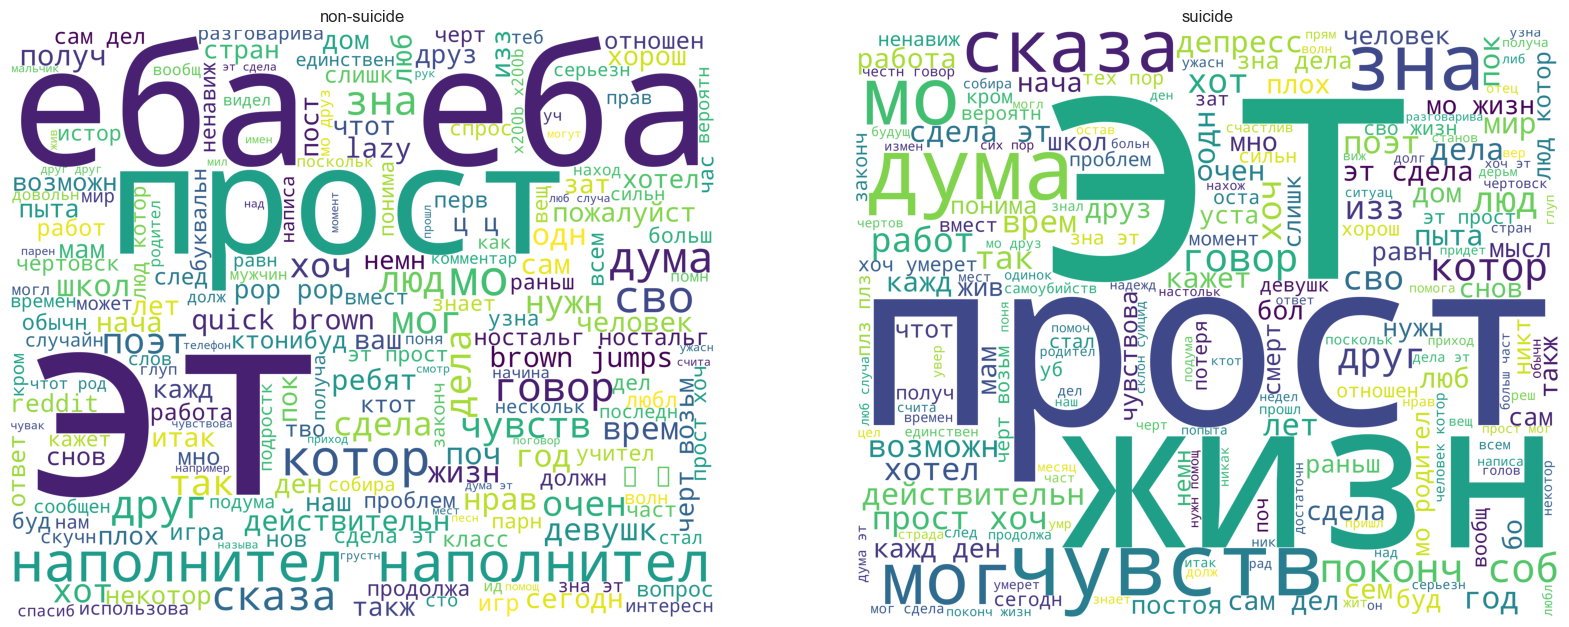

In [86]:
# Create a figure with a specified size
fig = plt.figure(figsize=(20, 8))

# Get the corpus for non-suicide tweets using the 'tweet_stem' column in the DataFrame
corpus_non_suicide = get_corpus(df_tweets[df_tweets['sentiment'] == 'non-suicide']['tweet_stem'].values)

# Generate a WordCloud for the non-suicide tweets
wordcloud_non_suicide = get_wordcloud(corpus_non_suicide)

# Plot the WordCloud for non-suicide tweets in the first subplot
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_non_suicide)
plt.title('non-suicide')
plt.axis('off')

# Get the corpus for suicide tweets using the 'tweet_stem' column in the DataFrame
corpus_suicide = get_corpus(df_tweets[df_tweets['sentiment'] == 'suicide']['tweet_stem'].values)

# Generate a WordCloud for the suicide tweets
wordcloud_suicide = get_wordcloud(corpus_suicide)

# Plot the WordCloud for suicide tweets in the second subplot
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_suicide)
plt.title('suicide')
plt.axis('off')

# Show the figure with both WordClouds
plt.show();

Подготовим данные для моделирования

In [12]:
# Drop the 'tweet' column from the DataFrame
df_tweets_preprocessed = df_tweets.drop('tweet', axis=1)

# Drop duplicate rows in the preprocessed DataFrame
df_tweets_preprocessed.drop_duplicates(inplace=True)

# Drop rows with missing values in the preprocessed DataFrame
df_tweets_preprocessed.dropna(inplace=True)

Закодируем целевую переменную

In [13]:
# Instantiate a LabelEncoder
label_encoder = LabelEncoder()

# Encode the 'sentiment' column in the DataFrame
df_tweets_preprocessed['sentiment'] = label_encoder.fit_transform(df_tweets_preprocessed['sentiment'])

# Access the classes that were encoded
classes_encoded = label_encoder.classes_

# Print the encoded classes
print(classes_encoded)

['non-suicide' 'suicide']


## Подбор лучшей простой модели

Выберем random state для  воспроизводимости результатов при повторном запуске кода.

In [14]:
RANDOM_STATE = 42

Создадим пайплайн для перебора моделей

In [15]:
final_p = Pipeline(steps=[
    ('model', LogisticRegression())
])

Создадим словарь с перебираемыми моделями

In [16]:
param_grid = [
    {
        'model': [
            LogisticRegression(random_state=RANDOM_STATE),
            MultinomialNB(),
            SVC(kernel='linear', probability=True, random_state=RANDOM_STATE),
            RandomForestClassifier(random_state=RANDOM_STATE)
        ]          
    }
]

Создадим сам объект GridSearchCV, который будет перебирать модели и оценивать их на кросс валидации

In [17]:
grid_search = GridSearchCV(
    final_p,          # 'final_p' is the pipiline
    param_grid,        # 'param_grid' is a dictionary specifying to search over
    cv=5,              # 'cv' is the number of cross-validation folds
    scoring='roc_auc', # 'scoring' is the evaluation metric used for optimization (ROC AUC in this case)
    n_jobs=-1          # 'n_jobs' is the number of CPU cores to use for parallelization (-1 means using all available cores)
)

Разбиение данных на целевой и входной признаки

In [18]:
X = df_tweets_preprocessed['tweet_stem']
y = df_tweets_preprocessed['sentiment']

Разбиение данных на тренировочную и тестовую выборки

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

Векторизуем твиты

In [20]:
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data to TF-IDF representation
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data using the same TF-IDF vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)

Воспользуемся поиском по секте для нахождения наилучшей модели

In [21]:
# Fit the GridSearchCV object on the TF-IDF transformed training data and labels
grid_search.fit(X_train_tfidf, y_train)

# Retrieve the best-performing model from the search
best_model_classification = grid_search.best_estimator_

Выведем параметры лучшей модели на экран

In [22]:
print('Лучшая модель и её параметры:\n\n', best_model_classification)
print ('Метрика лучшей модели на тренировочной выборке:', grid_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('model',
                 SVC(kernel='linear', probability=True, random_state=42))])
Метрика лучшей модели на тренировочной выборке: 0.9645296918535646


Посмотрим на результаты работы других моделей

In [23]:
results_df = pd.DataFrame(grid_search.cv_results_)
sorted_results = results_df.sort_values(by='mean_test_score', ascending=False)
print('Оценка моделей:')
sorted_results = sorted_results[['params', 'mean_test_score']]
sorted_results

Оценка моделей:


## Подбор гиперпараметров лучшей модели

Воспользуемся OptunaSearch для подбора гиперпараметров

In [24]:
# Define hyperparameter search space using Optuna distributions
parameters = {
    'kernel': distributions.CategoricalDistribution(['linear', 'rbf', 'poly']),
    'C': distributions.FloatDistribution(low=0.01, high=100.0, log=True),
    'gamma': distributions.FloatDistribution(low=0.001, high=1.0, log=True)
}

# Create an SVM classifier with probability estimates
model_svc = SVC(random_state=RANDOM_STATE, probability=True)

# Set up OptunaSearchCV for hyperparameter optimization
oscv = OptunaSearchCV(
    model_svc,                  # Classifier to be optimized
    parameters,                 # Hyperparameter search space
    cv=5,                       # Number of cross-validation folds
    n_trials=15,                # Number of optimization trials
    scoring='roc_auc',          # Evaluation metric for optimization
    verbose=0,                  # Verbosity level (0 for no output)
    random_state=RANDOM_STATE   # Random state for reproducibility
)

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.


Найдём лучший набор гиперпараметров

In [25]:
# Fit the OptunaSearchCV object on the TF-IDF transformed training data and labels
oscv.fit(X_train_tfidf, y_train)

# Print the best hyperparameters found during the optimization
print("Best hyperparameters:", oscv.best_params_)

# Retrieve the best SVM model from the search
best_svm_model = oscv.best_estimator_

[I 2024-02-02 13:48:52,673] A new study created in memory with name: no-name-53180739-0fc6-4e18-884d-947dd0302891
[I 2024-02-02 13:55:51,314] Trial 0 finished with value: 0.9200153325641759 and parameters: {'kernel': 'rbf', 'C': 0.18957846572342554, 'gamma': 0.02854707256092785}. Best is trial 0 with value: 0.9200153325641759.
[I 2024-02-02 14:00:24,441] Trial 1 finished with value: 0.9448124914843741 and parameters: {'kernel': 'linear', 'C': 0.05068567405352181, 'gamma': 0.00902891843360715}. Best is trial 1 with value: 0.9448124914843741.
[I 2024-02-02 14:07:15,193] Trial 2 finished with value: 0.9187237376954245 and parameters: {'kernel': 'rbf', 'C': 0.088764223829748, 'gamma': 0.014714978674351281}. Best is trial 1 with value: 0.9448124914843741.
[I 2024-02-02 14:14:02,907] Trial 3 finished with value: 0.923929918457677 and parameters: {'kernel': 'poly', 'C': 0.6876455645022199, 'gamma': 0.7196813352927308}. Best is trial 1 with value: 0.9448124914843741.
[I 2024-02-02 14:21:03,810

Best hyperparameters: {'kernel': 'rbf', 'C': 3.7014279142044115, 'gamma': 0.0727675403200646}


### Проверка модели на тестовых данных

Создадим функцию для оценки модели

In [26]:
def check_model(model, X, y):
    # Make predictions and calculate probability estimates
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y, y_proba)
    roc_auc = auc(fpr, tpr)

    # Display classification report
    print(classification_report(y, y_pred))

    # Confusion Matrix
    conf_mat = confusion_matrix(y, y_pred, normalize='true')

    # Create a subplot with 1 row and 2 columns
    plt.figure(figsize=(12, 6))

    # Plot Confusion Matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(conf_mat, annot=True, fmt='1.2f', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title('Confusion Matrix')

    # Plot ROC Curve
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f}%)'.format(roc_auc * 100))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plots
    plt.show()

Проверка SVC модели со стандартными гиперпараметрами

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1257
           1       0.93      0.90      0.92      1243

    accuracy                           0.92      2500
   macro avg       0.92      0.92      0.92      2500
weighted avg       0.92      0.92      0.92      2500


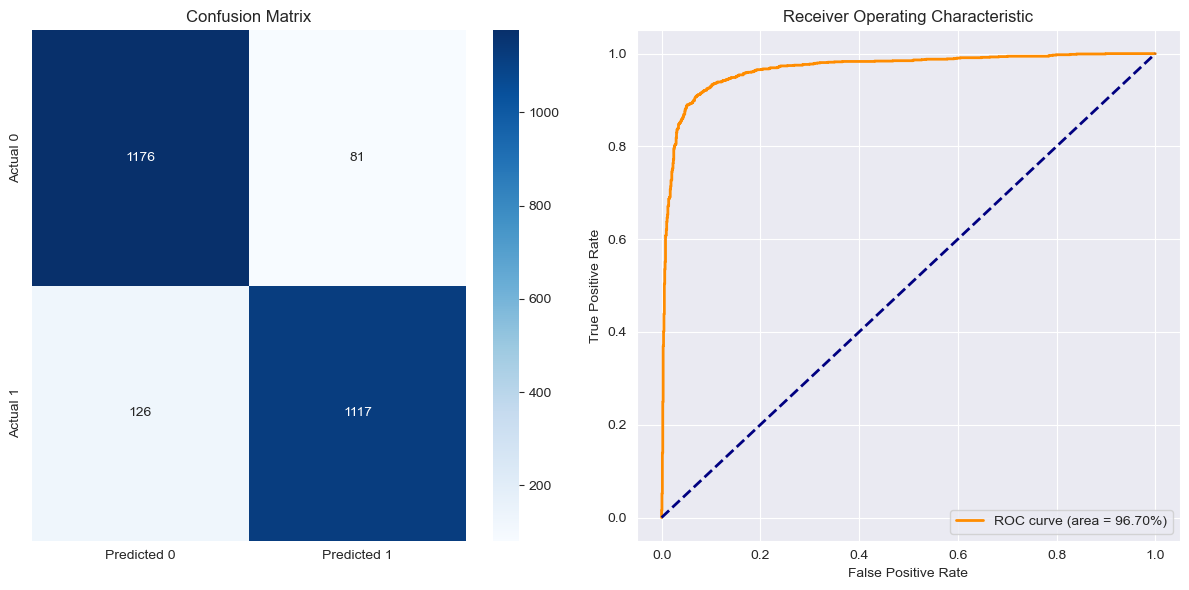

In [27]:
check_model(best_model_classification, X_test_tfidf, y_test)

Проверка SVC модели с подобранными гиперпараметрами

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1257
           1       0.94      0.89      0.92      1243

    accuracy                           0.92      2500
   macro avg       0.92      0.92      0.92      2500
weighted avg       0.92      0.92      0.92      2500


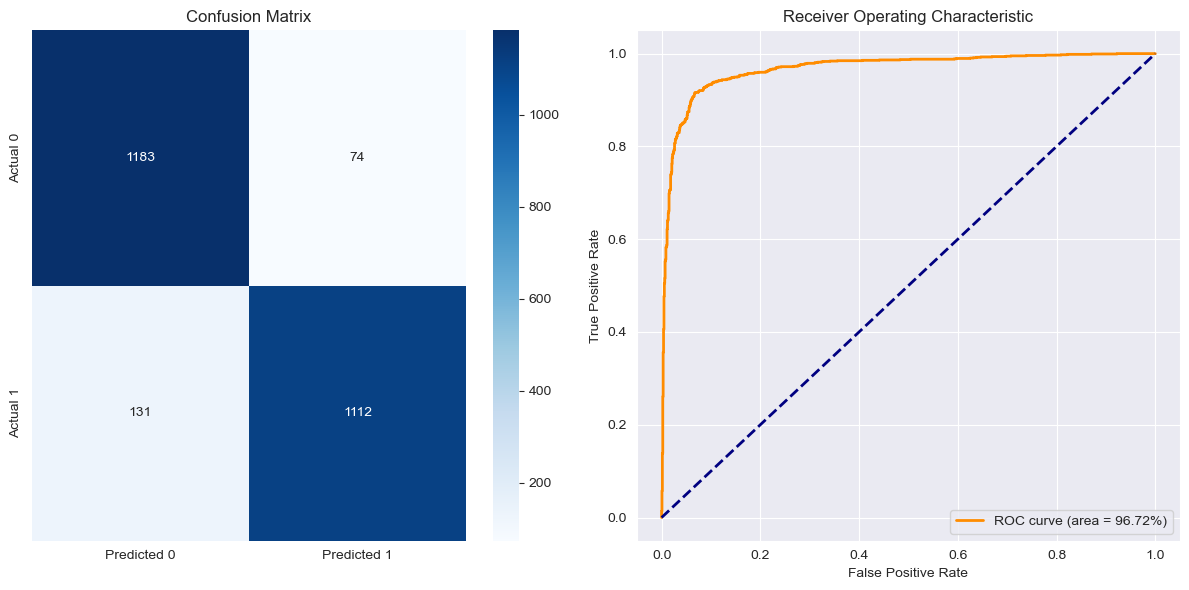

In [28]:
check_model(best_svm_model, X_test_tfidf, y_test)

## Использование более сложной модели

Воспользуемся более продвинутой моделью CatBoost для той же задачи

In [29]:
# Instantiate a CatBoostClassifier with specified parameters
model = CatBoostClassifier(iterations=500, depth=5, learning_rate=0.05, loss_function='Logloss', rsm=0.8, verbose=False)

# Fit the model on the TF-IDF transformed training data and labels
model.fit(X_train_tfidf, y_train);

0:	learn: 0.6607542	total: 382ms	remaining: 3m 10s
1:	learn: 0.6358970	total: 569ms	remaining: 2m 21s
2:	learn: 0.6117564	total: 822ms	remaining: 2m 16s
3:	learn: 0.5881745	total: 1.04s	remaining: 2m 9s
4:	learn: 0.5684796	total: 1.26s	remaining: 2m 4s
5:	learn: 0.5510553	total: 1.47s	remaining: 2m
6:	learn: 0.5340683	total: 1.67s	remaining: 1m 57s
7:	learn: 0.5204586	total: 1.9s	remaining: 1m 56s
8:	learn: 0.5091729	total: 2.09s	remaining: 1m 54s
9:	learn: 0.4983763	total: 2.29s	remaining: 1m 52s
10:	learn: 0.4871334	total: 2.49s	remaining: 1m 50s
11:	learn: 0.4766887	total: 2.7s	remaining: 1m 49s
12:	learn: 0.4673527	total: 2.94s	remaining: 1m 49s
13:	learn: 0.4582350	total: 3.16s	remaining: 1m 49s
14:	learn: 0.4518713	total: 3.38s	remaining: 1m 49s
15:	learn: 0.4451823	total: 3.62s	remaining: 1m 49s
16:	learn: 0.4380339	total: 3.83s	remaining: 1m 48s
17:	learn: 0.4338734	total: 4.05s	remaining: 1m 48s
18:	learn: 0.4286177	total: 4.29s	remaining: 1m 48s
19:	learn: 0.4248520	total: 4.

Посмотрим на метрику CatBoost на тренировочной выборке

In [30]:
# Calculate the ROC-AUC score for the CatBoost model on the training set
catBoost_roc_auc = roc_auc_score(y_train, model.predict_proba(X_train_tfidf)[:, 1])

# Print the ROC-AUC score
print("ROC-AUC score =", catBoost_roc_auc)

ROC-AUC score = 0.9870368424486202


Как видим метрика завышена, скорее всего произошло переобучение и на тестовых данных результат будет не таким впечатляющим

Проверка CatBoost на тестовых данных

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      1257
           1       0.93      0.86      0.89      1243

    accuracy                           0.90      2500
   macro avg       0.90      0.90      0.90      2500
weighted avg       0.90      0.90      0.90      2500


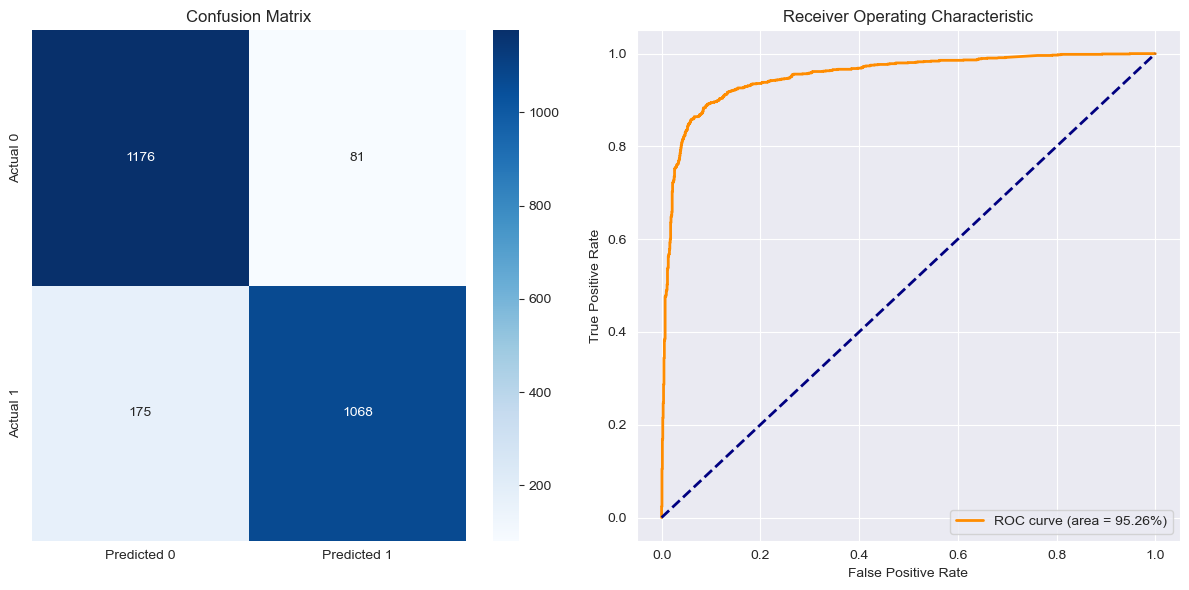

In [31]:
check_model(model, X_test_tfidf, y_test)

## Заключение
* При обработке твитов были убраны знаки препинания и стоп слова, при этом остальной тест был разбит на токены и обработан с помощью SnowballStemmer а затем векторизован используя TfidfVectorizer.
* Использовалось 5 моделей - SVC, LogisticRegression, RandomForest, MultinomialNB и CatBoost, как показала практика первые 4 модели хоть и были проще, но показали высокую эффективность их roc-auc score не сильно отличался от CatBoost, при этом скорость обучения в разы выше.
* Лучшей моделью стала SVC с roc-auc score = 0.967 на тестовой выборке